In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.nn import functional 
from pydub import AudioSegment
import librosa

In [14]:
MAPPING = {
    "acoustic" : 0,
    "blues" : 1,
    "classical" : 2,
    "country" : 3,
    "dance" : 4,
    "edm" : 5,
    "hip-hop" : 6,
    "indie" : 7,
    "jazz" : 8,
    "pop" : 9,
    "rock" : 10,
    "world-music" : 11
}

IMG_FOLDER = "spectrogram"

genres = os.listdir(IMG_FOLDER)

#! Using zeros instead of empty because empty needs dtypes
images = np.zeros(shape = (1195, 4, 369, 496))
labels = np.zeros(shape = 1195)

# Generate images and labels
idx = 0
added = []
for root, directories, contents in os.walk(IMG_FOLDER):
    if root == IMG_FOLDER: continue
    genre = root.split('/')[1]
    if genre in MAPPING:
        for img_path in contents:
            image = plt.imread(root + "/" + img_path)
            ## Convert to tensor and check the shape
            spec = torch.from_numpy(image)

            ## Move third dimension (color channels)
            ## to the first dimension
            spec2 = torch.movedim(spec, source=2, destination=0)

            ## Add an empty first dimension, 
            ## putting our tensor into the standard format
            spec_final = torch.unsqueeze(spec2, dim=0)
            
            ### 389 / 6 = 65 and 515 / 6 = 86
            # spec_resized = functional.interpolate(spec_final, 
            #                                       size = (65,86)) 

            images[idx] = spec_final
            labels[idx] = MAPPING[genre]
            idx += 1

In [12]:
## Train-test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(images, labels, 
                                                    test_size=0.25, random_state=5)

In [81]:
# Data Loaders
from torch.utils.data import DataLoader, TensorDataset

bsize=10

y_tensor = torch.Tensor(train_y)
X_tensor = torch.from_numpy(train_X)

train_loader = DataLoader(
  TensorDataset(
    X_tensor.type(torch.FloatTensor), 
    y_tensor.type(torch.LongTensor)),
  batch_size=bsize
)

In [82]:
# Import EfficientNet model -- Using b0 for speed 
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)

# Alter Efnet to receive 4 channels (RGBY) instead of 3 (RGB)
# https://stackoverflow.com/questions/67821830/using-3-channel-rgb-pytorch-model-for-classification-4-channel-rgby-images
efnet_model.features[0][0] = torch.nn.Conv2d(4, 32, kernel_size=(3, 3), padding=(1, 1), bias=False)

# Use Feature Extraction
for param in efnet_model.features.parameters():
    param.requires_grad = False

# Replace the "classifier" layer with one for our application
num_cats = len(MAPPING) # 12
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=num_cats, bias=True)
)

In [83]:
## Hyperparms
epochs = 20
lrate = 0.01

## Cost Function
from torch import nn
cost_fn = nn.CrossEntropyLoss()

## Network model
torch.manual_seed(3)
net = efnet_model

## Optimizer (using ADAM, a more flexible algorithm than SGD this time)
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)

## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(0, epochs):
    
    cur_cost = 0

    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores 
        ## and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch+1} Cost: {cur_cost}") ## Uncomment this if you want printed updates   

Epoch: 1 Cost: 147.78980922698975


KeyboardInterrupt: 

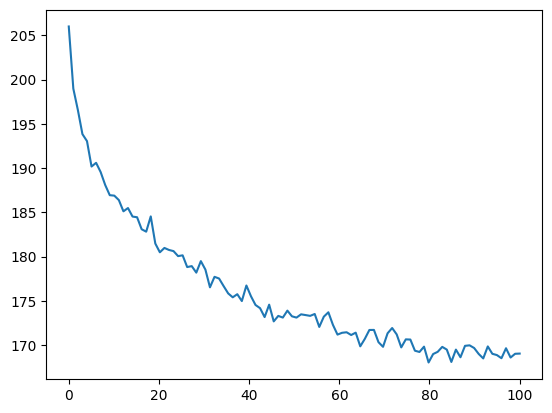

In [66]:
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [67]:
# Evaluate performance on test data
correct = 0
total = 0

## Convert data frame to Tensor for DataLoader
y_test_tensor = torch.Tensor(test_y)
X_test_tensor = torch.from_numpy(test_X)
test_loader = DataLoader(TensorDataset(X_test_tensor.type(torch.FloatTensor), 
                        y_test_tensor.type(torch.LongTensor)), batch_size=bsize)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct/total)

0.3779264214046823


In [84]:
# Functions to make predictions on a single input 

def generate_one_spectrogram(input_filename):
    TEST_PATH = 'test_files/'

    ### Generate spectrogram
    src = TEST_PATH + input_filename + '.mp3'
    dst = TEST_PATH + input_filename + '.wav'
                                 
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

    SAMPLE_RATE = 22050
    y, sr = librosa.load(dst,sr=SAMPLE_RATE)
            
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                            fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=8000, ax=ax)
    
    plt.axis('off')
    plt.savefig(TEST_PATH + input_filename + ".png", bbox_inches='tight', pad_inches=0)
    return TEST_PATH + input_filename + ".png"

def convert_img_to_tensor(img_filename):
    image = plt.imread(img_filename)

    ## Convert to tensor and check the shape
    spec = torch.from_numpy(image)

    ## Move third dimension (color channels) to the first dimension
    spec2 = torch.movedim(spec, source=2, destination=0)

    ## Add an empty first dimension, 
    ## putting our tensor into the standard format
    spec_final = torch.unsqueeze(spec2, dim=0)
    
    # spec_resized = functional.interpolate(spec_final, size = (369, 496))
    
    ## spec_img_format = torch.movedim(spec_resized[0], source=0, destination=2)

    print(spec_final.shape)
    
    return spec_final


CATEGORY_LABEL = ["acoustic", "blues", "classical", "country","dance","edm",
                  "hip-hop","indie","jazz","pop","rock","world-music"]

def predict(input_filename, n_predictions=6):
    print('\n> %s' % input_filename)

    spectrogram_filename = generate_one_spectrogram(input_filename)
    img_tensor = convert_img_to_tensor(spectrogram_filename)
    
    ## Don't update gradient with any of these examples
    with torch.no_grad():
        
        output = net(img_tensor)
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        ## Actual label
        actual_category = input_filename.split('_')[0]
        print(f"\nActual Genre: {actual_category}\n")
        
        ## Go through the category predictions and save info for printing
        print("Top Predicted Genres:")
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, CATEGORY_LABEL[category_index]))
            predictions.append([value, CATEGORY_LABEL[category_index]])


> acoustic_93-million-miles
torch.Size([1, 4, 369, 496])

Actual Genre: acoustic

Top Predicted Genres:
(11.18) acoustic
(-10.91) country
(-11.08) pop
(-11.09) rock
(-11.13) edm
(-11.15) indie


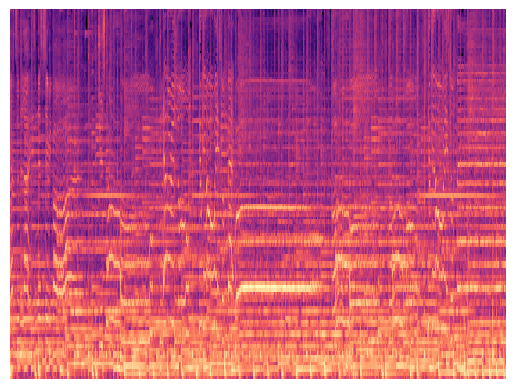

In [85]:
### Download an mp3 file in the `test_files` directory and input the filename to predict() 
### -- ex. predict("shape_of_you")
predict("acoustic_93-million-miles")


> classical_concerto-for-2-cellos-in-g-minor-rv-531-i-allegro-live
torch.Size([1, 4, 65, 86])

Actual Genre: classical

Top Predicted Genres:
(7.39) acoustic
(-1.11) pop
(-5.36) world-music
(-9.07) classical
(-11.84) jazz
(-12.06) blues


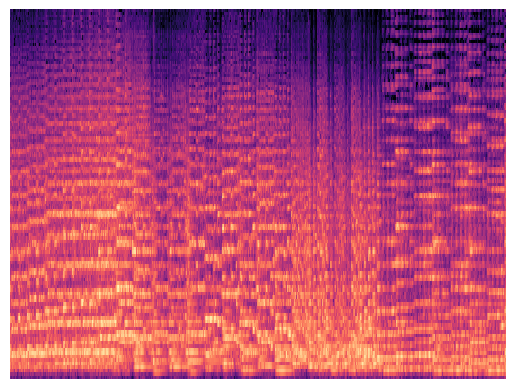

In [75]:
predict("classical_concerto-for-2-cellos-in-g-minor-rv-531-i-allegro-live")



> jazz_just-the-two-of-us-feat-bill-withers
torch.Size([1, 4, 65, 86])

Actual Genre: jazz

Top Predicted Genres:
(6.80) acoustic
(-3.83) world-music
(-6.78) pop
(-8.55) indie
(-11.30) classical
(-12.01) jazz


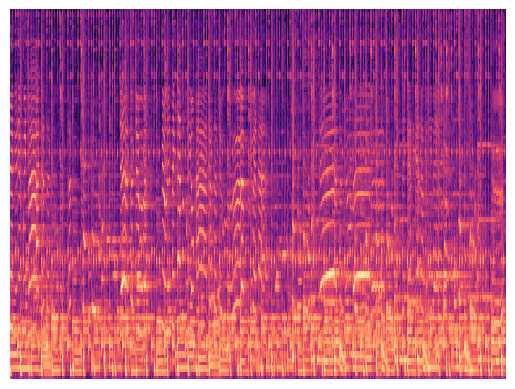

In [76]:
predict("jazz_just-the-two-of-us-feat-bill-withers")

NameError: name 'net' is not defined